# David Bau stream test task
### Darius Kianersi

Given the following type of prompt, a sufficiently large language model will be able to answer with the correct number.
```
Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
Type: fruit
List: [dog apple cherry bus cat grape bowl]
Answer: (
```
1. create a dataset of several thousand examples like this.
2. benchmark some open-weight LMs on solving this task zero-shot (without reasoning tokens)
3. for a single model, create a causal mediation analysis experiment (patching from one run to another) to answer: "is there a hidden state layer that contains a representation of the running count of matching words, while processing the list of words?"

In [1]:
import os
import json
from IPython.display import clear_output
from typing import Literal, Type, TypeAlias
import random
from __future__ import annotations
from typing import TypedDict, List, Literal, Any
import collections
from tqdm import tqdm


from openai import OpenAI
import pandas as pd
from pydantic import BaseModel
from dotenv import load_dotenv
import torch
import matplotlib.pyplot as plt

load_dotenv()

True

### 1. Create a dataset of these examples
Here's my high-level plan:
1. Generate a few word types that are mutually exclusive (this makes it easier to get ground truth values).
2. Generate some words for each type.
3. Sample a balanced dataset of words and a type, then compute the answer for the given type.

In [90]:
client = OpenAI()
MODEL = "gpt-4.1"

In [91]:
# 1. Structured-output schemas
class WordTypeList(BaseModel):
    categories: List[str] # e.g. ["animals", "fruits", "utensils"]

class Word(BaseModel):
    name: str # e.g. "trumpet"
    word_type: str # e.g. "musical instruments"

class WordList(BaseModel):
    words: List[Word]

In [92]:
# 2. Helpers that wrap the chat.completions.parse call
def get_word_types(n: int = 6) -> List[str]:
    """Return mutually-exclusive word categories."""
    messages = [
        {"role": "system",
         "content": "Return a JSON object with one field 'categories' "
                    "containing a list of mutually-exclusive word types."},
        {"role": "user",
         "content": f"Generate {n} mutually exclusive word types like "
                    "'animals', 'fruits', 'utensils'. "
                    "Do NOT include overlapping concepts."}
    ]
    resp: WordTypeList = client.beta.chat.completions.parse(
        model=MODEL,
        messages=messages,
        response_format=WordTypeList,
    )
    return json.loads(resp.choices[0].message.content)["categories"]


def get_words_for_type(target: str, others: List[str],
                       k_min: int = 10, k_max: int = 20) -> List[Word]:
    """Return Word objects for one category, avoiding overlap with others."""
    messages = [
        {"role": "system",
         "content": "Return a JSON object with one field 'words': "
                    "a list of objects each having 'name' and 'word_type'."},
        {"role": "user",
         "content": f"""Generate {k_min}-{k_max} distinct words that are **{target}**.
These words must **not** also fit any of the following types:
{', '.join(others)}.
Return each as an object: \"name\": <word>, \"word_type\": \"{target}\".
Exclude plurals if the singular form is already present; no extras.""",}
    ]
    resp: WordList = client.beta.chat.completions.parse(
        model=MODEL,
        messages=messages,
        response_format=WordList,
    )
    return json.loads(resp.choices[0].message.content)["words"]


# 3. Build the full dataset
def build_dataset() -> List[Word]:
    categories = get_word_types()
    dataset: List[Word] = []
    for t in categories:
        others = [o for o in categories if o != t]
        dataset.extend(get_words_for_type(t, others))
    return dataset


# 4. Sample and tally helpers
def random_sample(words: List[Word], n: int = 8) -> List[Word]:
    return random.sample(words, n)

def tally_by_type(words: List[Word]) -> dict[str, int]:
    counter = collections.Counter(w["word_type"] for w in words)
    return dict(counter)


In [93]:
all_words = build_dataset()
print(f"Generated {len(all_words)} total words across "
        f"{len(set(w['word_type'] for w in all_words))} types.")

sample = random_sample(all_words, 12)
print("\n Random sample:")
for w in sample:
    print(f"  {w['name']:>12s}  —  {w['word_type']}")

counts = tally_by_type(all_words)
print("\n Counts by category:")
for typ, cnt in counts.items():
    print(f"  {typ:<20s}: {cnt}")


Generated 118 total words across 6 types.

 Random sample:
      rambutan  —  fruits
       Persian  —  languages
     ambulance  —  vehicles
   rice paddle  —  utensils
        zester  —  utensils
       apricot  —  fruits
         sitar  —  musical instruments
    tambourine  —  musical instruments
        papaya  —  fruits
        cherry  —  fruits
          harp  —  musical instruments
       panther  —  animals

 Counts by category:
  animals             : 20
  fruits              : 20
  utensils            : 20
  vehicles            : 18
  languages           : 20
  musical instruments : 20


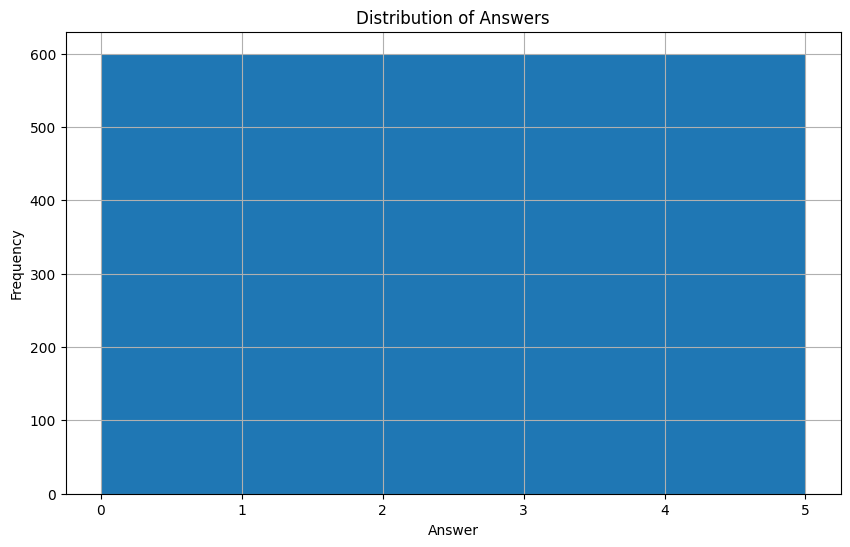

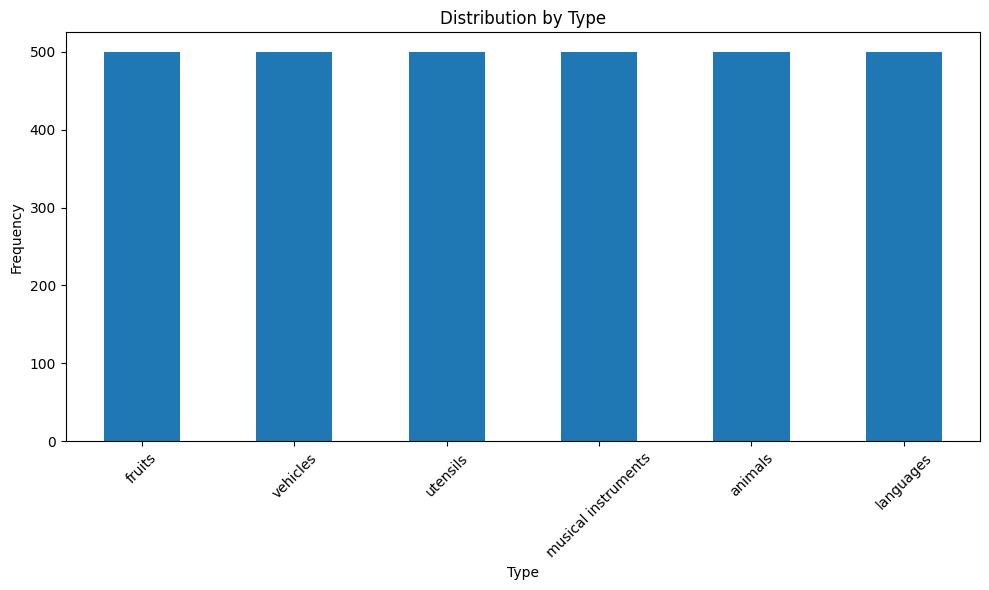


Total number of samples: 3000

Example samples:

Type: fruits
List: ['grater', 'mango', 'peach', 'apricot', 'papaya', 'scooter', 'skimmer', 'czech']
Answer: (4)

Type: vehicles
List: ['elephant', 'norwegian', 'skimmer', 'rice paddle']
Answer: (0)

Type: utensils
List: ['tram', 'truck', 'grater', 'masher', 'guava']
Answer: (2)

Type: musical instruments
List: ['masher', 'zester', 'violin', 'vietnamese', 'lychee']
Answer: (1)

Type: musical instruments
List: ['cleaver', 'banjo', 'mandolin', 'jeep', 'bicycle', 'marimba']
Answer: (3)


In [105]:
def generate_balanced_samples(all_words, answers_range=(0, 4), samples_per_answer=10):
    """
    Generate balanced samples where:
    - Each possible answer (0-4) has the same number of samples
    - Each word type has the same number of samples
    - For each answer and type combination, generate multiple samples
    """
    # Get all unique types
    all_types = list(set(w["word_type"].lower() for w in all_words))
    
    # Group words by type for easier access
    words_by_type = {
        t.lower(): [w for w in all_words if w["word_type"].lower() == t.lower()]
        for t in all_types
    }
    
    # Store all generated samples
    samples = []
    
    # For each type
    for target_type in all_types:
        # For each desired answer
        for target_answer in range(answers_range[0], answers_range[1] + 1):
            # Generate multiple samples for this type-answer combination
            for _ in range(samples_per_answer):
                # 1. First, decide total list length (should be reasonable given target_answer)
                min_len = max(4, target_answer)  # At least 4 words, or enough to fit target_answer
                max_len = min(8, target_answer + 4)  # Cap at 8, or target_answer + 4
                total_len = random.randint(min_len, max_len)
                
                # 2. Select target_answer words of the target type
                target_words = random.sample(words_by_type[target_type], target_answer)
                
                # 3. Fill remaining slots with words from other types
                remaining_slots = total_len - target_answer
                other_words = []
                if remaining_slots > 0:
                    # Pool of words from other types
                    other_types_words = [
                        w for w in all_words 
                        if w["word_type"].lower() != target_type
                    ]
                    other_words = random.sample(other_types_words, remaining_slots)
                
                # 4. Combine and shuffle
                all_selected_words = target_words + other_words
                random.shuffle(all_selected_words)
                
                # 5. Create the sample
                word_list = [w["name"].lower() for w in all_selected_words]
                
                samples.append({
                    "type": target_type.lower(),
                    "list": word_list,
                    "answer": target_answer
                })
    
    # Shuffle all samples
    random.shuffle(samples)
    return samples

# Test the function
samples = generate_balanced_samples(all_words, answers_range=(0, 4), samples_per_answer=100)

# Create dataframe and plot distributions
df = pd.DataFrame(samples)

# Plot distribution by answer
plt.figure(figsize=(10, 6))
df['answer'].hist(bins=range(df['answer'].min(), df['answer'].max() + 2, 1))
plt.title('Distribution of Answers')
plt.xlabel('Answer')
plt.ylabel('Frequency')
plt.show()

# Plot distribution by type
plt.figure(figsize=(10, 6))
type_counts = df['type'].value_counts()
type_counts.plot(kind='bar')
plt.title('Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Frequency') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Print basic statistics about the samples
print(f"\nTotal number of samples: {len(df)}")
# Print a few example samples
print("\nExample samples:")
for i, sample in df.head().iterrows():
    print(f"\nType: {sample['type']}")
    print(f"List: {sample['list']}")
    print(f"Answer: ({sample['answer']})")

# Save the dataframe to disk
df.to_csv('counting_samples.csv', index=False)

### 2. Eval some open-weight models on this task
Let's eval GPT-2 as well as Llama-3.1-8B and Llama-3.1-70B.

I'll use the Inspect library from UK AISI for GPT-2; however, afaict it doesn't allow for completions, so I'll reformat the prompt to be conversational/a chat.

In [9]:
from pprint import pprint
from inspect_ai.dataset import Sample, csv_dataset
from inspect_ai.model import ChatMessageAssistant, ChatMessageSystem, ChatMessageUser

CHAT_QUESTION_TEMPLATE = """Count the number of words in the following list that match the given type, respond with the numerical answer only.
Type: {type}
List: {list}
Answer: """

def format_sample_chat(record: dict[str, Any]) -> Sample:
    """
    Formats counting dataset into inspect_ai Sample objects.
    """
    input = CHAT_QUESTION_TEMPLATE.format(type=record["type"], list=" ".join(eval(record["list"])))
    target = str(record["answer"])

    # return sample
    return Sample(input=input, target=target)

dataset = csv_dataset("counting_samples.csv", name="Counting", sample_fields=format_sample_chat)
pprint(dataset.samples[0].__dict__)


{'choices': None,
 'files': None,
 'id': None,
 'input': 'Count the number of words in the following list that match the '
          'given type, respond with the numerical answer only.\n'
          'Type: fruits\n'
          'List: grater mango peach apricot papaya scooter skimmer czech\n'
          'Answer: ',
 'metadata': None,
 'sandbox': None,
 'setup': None,
 'target': '4'}


In [24]:
from inspect_ai import Task, task
from inspect_ai import eval as inspect_eval
from inspect_ai.scorer import exact
from inspect_ai.solver import generate

@task
def counting_task() -> Task:
    return Task(
        dataset=dataset,
        solver=[generate()],
        scorer=exact(),
    )

# model_name = "openai/gpt-4o-mini"
model_name = "hf/openai-community/gpt2"
# model = get_model(model_name, device="cuda:0")
results = inspect_eval(counting_task(), model=model_name, max_tokens=1, limit=3000, log_format="eval", log_dir="logs")


Output()

Accuracy is ~0.16%, which is 5 samples out of 3000 counted correctly. GPT-2 is quite small (120M), so we don't expect much better. 

Let's try Llama-3.1-8B. For this, I'll create my own eval harness using the original completion prompt.

In [2]:
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader

COMPLETION_QUESTION_TEMPLATE = """Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
Type: {type}
List: {list}
Answer: ("""
device = 'cuda'

class CountingDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        formatted_prompt = COMPLETION_QUESTION_TEMPLATE.format(type=row["type"], list=" ".join(eval(row["list"])))
        return formatted_prompt, str(row['answer'])

def collate_fn(batch, tokenizer):
    formatted_prompts, answers = zip(*batch)
    x = tokenizer(formatted_prompts, return_tensors="pt", padding=True)
    y = tokenizer(answers, add_special_tokens=False, return_tensors="pt")
    return x, y

dataset = CountingDataset("counting_samples.csv")

In [3]:
from functools import partial

def eval_model(model, dataset, tokenizer):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=partial(collate_fn, tokenizer=tokenizer))
    total_correct = 0
    total_seen = 0
    pbar = tqdm(dataloader, total=len(dataset)//dataloader.batch_size)
    for x, y in pbar:
        with torch.inference_mode():
            out = model(input_ids=x['input_ids'].to(device), attention_mask=x['attention_mask'].to(device))
            logits = out.logits
            probs = logits[:, -1].softmax(dim=-1)
            next_toks = torch.argmax(probs, dim=-1, keepdim=True)
            total_correct += (next_toks == y['input_ids'].to(device)).sum()
            total_seen += len(x['input_ids'])
            pbar.set_description(f"Acc: {total_correct/total_seen:.2%}")
    pbar.close()

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "meta-llama/Meta-Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
llama_8b = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=partial(collate_fn, tokenizer=tokenizer))

eval_model(llama_8b, dataset, tokenizer)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Acc: 44.77%: : 94it [00:05, 16.43it/s]                      


44% is much better, especially since this isn't a multiple choice eval — the model sees between 4 and 8 words in each list, so this is better than random guessing based off the list length.

However, we'd probably still like a greater accuracy to be confident the circuit exists and the model doesn't just have decent guesswork heuristics. Let's try 70B.

In [ ]:
model_id = "meta-llama/Meta-Llama-3.1-70B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
llama_70b = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [37]:
eval_model(llama_70b, dataset, tokenizer)

Acc: 64.87%: : 94it [00:40,  2.34it/s]                      


### 3. Causal Mediation Analysis
I have two ideas for what the circuit might look like:
1. Model is keeping a running count of fruits
    - Attn is moving the current count from a prev position to current position, updating it (+1) with the MLP
    - Final answer attends to last fruit, gets its count
2. Model only stores whether each position is a fruit, adds them together at the end
    - Attention on a given fruit doesn't move info from previous fruits
    - Each position keeps track of whether it's a fruit (0 or 1)
    - Final answer attends to all previous fruits, adds them all together in the MLP

I unfortunately was not able to complete this section. I ran into several memory issues trying to activation patch Llama-3.1-70B that I didn't have time to debug.
1. I first tried the `nnsight` library with a remote NDIF instance of the model. This worked for the clean and corrupted forward passes; however, when I tried to batch over all of the layers and token positions with `tracer.invoke`, the job would mysteriously get killed without any error message. I suspected this was an OOM, so I refactored the code to iteratively call `tracer.trace` without batching, but this was unusably slow (1 iter/~30m)
2. I used on-demand compute to locally serve the model; however, this OOMed in the batched pass, even when iterating over layers and only batching on the token positions.
3. I then tried the `transformer_lens` library, but had no luck here either. The model was not sharding across my GPUs properly and failed with device asserts.

If given more time, I would have tried first attribution patching to localize some layers and positions with a cheaper operation (2 fwd passes and 1 bckwd).

In [ ]:
from nnsight import NNsight, LanguageModel, CONFIG
CONFIG.set_default_api_key(os.getenv("NDIF_API_KEY"))

In [ ]:
clean_prompt = """Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
Type: fruit
List: [dog apple cherry bus cat grape bowl]
Answer: ("""
corrupted_prompt = """Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
Type: fruit
List: [dog apple spoon bus cat grape bowl]
Answer: ("""
prompts = (clean_prompt, corrupted_prompt)

answers = ("3", "2")

In [ ]:
model = LanguageModel("meta-llama/Meta-Llama-3.1-70B", device_map="auto")

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [ ]:
tokens = model.tokenizer(prompts, return_tensors="pt")['input_ids']
print(f"{tokens=}")
correct_idx, incorrect_idx = [model.tokenizer(answer, add_special_tokens=False)['input_ids'][0] for answer in answers]

tokens=tensor([[128000,   2568,    279,   1396,    315,   4339,    304,    279,   2768,
           1160,    430,   2489,    279,   2728,    955,     11,    323,   2231,
            279,  35876,   4320,    304,  75075,    627,    941,     25,  14098,
            198,    861,     25,    510,  18964,  24149,  41980,   5951,   8415,
          52252,  19763,    933,  16533,     25,    320],
        [128000,   2568,    279,   1396,    315,   4339,    304,    279,   2768,
           1160,    430,   2489,    279,   2728,    955,     11,    323,   2231,
            279,  35876,   4320,    304,  75075,    627,    941,     25,  14098,
            198,    861,     25,    510,  18964,  24149,  46605,   5951,   8415,
          52252,  19763,    933,  16533,     25,    320]])


In [ ]:
N_LAYERS = len(model.model.layers)
with model.trace(clean_prompt) as tracer:
    clean_hs = [model.model.layers[layer_idx].output[0].save() for layer_idx in range(N_LAYERS)]
    clean_logits = model.lm_head.output

        # Calculate the difference between the correct answer and incorrect answer for the clean run and save it.
    clean_logit_diff = (clean_logits[0, -1, correct_idx] - clean_logits[0, -1, incorrect_idx]).save()

model.safetensors.index.json:   0%|          | 0.00/59.6k [00:00<?, ?B/s]

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00004-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00006-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00007-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00003-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00030.safetensors:   0%|          | 0.00/4.58G [00:00<?, ?B/s]

model-00002-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00005-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00008-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00009-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00010-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00011-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00012-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00013-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00014-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00015-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00016-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00017-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00018-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00019-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00020-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00021-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00022-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00023-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00024-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00025-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00026-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00027-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00028-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00029-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00030-of-00030.safetensors:   0%|          | 0.00/2.10G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
with model.trace(corrupted_prompt) as tracer:
    corrupted_logits = model.lm_head.output

        # Calculate the difference between the correct answer and incorrect answer for the corrupted run.
    corrupted_logit_diff = (corrupted_logits[0, -1, correct_idx] - corrupted_logits[0, -1, incorrect_idx]).save()

In [ ]:
ioi_patching_results = []
with model.trace() as tracer:
    for layer_idx in tqdm(range(N_LAYERS)):
        _ioi_patching_results = []

        # Iterate through all tokens
        for token_idx in range(len(tokens[-1])):
            # Patching corrupted run at given layer and token
            with tracer.invoke(corrupted_prompt) as invoker:
                # Apply the patch from the clean hidden states to the corrupted hidden states.
                model.model.layers[layer_idx].output[0][:, token_idx, :] = clean_hs[layer_idx][:, token_idx, :]

                patched_logits = model.lm_head.output

                patched_logit_diff = (
                    patched_logits[0, -1, correct_idx]
                    - patched_logits[0, -1, incorrect_idx]
                )

                # Calculate the improvement in the correct token after patching.
                patched_result = (patched_logit_diff - corrupted_logit_diff) / (
                    clean_logit_diff - corrupted_logit_diff
                )

                _ioi_patching_results.append(patched_result.item().save())

        ioi_patching_results.append(_ioi_patching_results)

100%|██████████| 80/80 [00:09<00:00,  8.22it/s]
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


NNsightError: CUDA out of memory. Tried to allocate 15.07 GiB. GPU 0 has a total capacity of 139.81 GiB of which 12.57 GiB is free. Process 349837 has 127.23 GiB memory in use. Of the allocated memory 124.99 GiB is allocated by PyTorch, and 1.57 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [2]:
from transformer_lens import patching
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.components import MLP, Embed, LayerNorm, Unembed
from transformer_lens.hook_points import HookPoint
from plotly.express import imshow

In [3]:
model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-3.1-70B",
    dtype=torch.float16,
    device='cuda',
    n_devices=4,
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-70B into HookedTransformer


In [4]:
# device = "cuda"
device_type = next(iter(model.parameters())).device.type
clean_prompt = """Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
Type: fruit
List: [dog apple cherry bus cat grape bowl]
Answer: ("""
corrupted_prompt = """Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
Type: fruit
List: [dog apple spoon bus cat grape bowl]
Answer: ("""
prompts = (clean_prompt, corrupted_prompt)

clean_tokens = model.to_tokens(clean_prompt).to(device_type)
corrupted_tokens = model.to_tokens(corrupted_prompt).to(device_type)

answers = ("3", "2")
answer_tokens = model.to_tokens(answers, prepend_bos=False).cpu()

In [6]:
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

def logits_to_ave_logit_diff(logits, answer_tokens):
    correct_token, incorrect_token = answer_tokens
    return (logits[0, -1, correct_token[0]] - logits[0, -1, incorrect_token[0]]) / 2

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)

def ioi_metric(logits, answer_tokens=answer_tokens, corrupted_logit_diff=corrupted_logit_diff, clean_logit_diff=clean_logit_diff):
    patched_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:3! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [19]:
clean_logit_diff.item(), corrupted_logit_diff.item()

(1.28125, -1.69921875)

In [47]:
act_patch_resid_pre = patching.get_act_patch_resid_pre(
    model=model, corrupted_tokens=corrupted_tokens, clean_cache=clean_cache, patching_metric=ioi_metric
)

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

imshow(
    act_patch_resid_pre,
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=700,
)

  0%|          | 0/3360 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 139.83 GiB of which 11.56 MiB is free. Including non-PyTorch memory, this process has 139.80 GiB memory in use. Of the allocated memory 138.93 GiB is allocated by PyTorch, and 216.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)